# WorkoutBuddy Database Exploration

This notebook provides comprehensive exploration and analysis of the WorkoutBuddy database.

## 📊 What you'll find here:
- Database connection and basic queries
- Exercise data analysis and visualization
- User and goal statistics (when available)
- Data quality checks
- Interactive visualizations
- Machine learning insights preparation

## 🚀 Setup and Imports

In [1]:
# Standard libraries
import os
import sys
import pandas as pd
import numpy as np
from collections import Counter
import warnings

warnings.filterwarnings("ignore")

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Database libraries
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker

# Configure plotting
plt.style.use("default")
sns.set_palette("husl")
%matplotlib inline

# Add app directory to path
sys.path.append("app")

print("✅ All imports successful!")

✅ All imports successful!


## 🔌 Database Connection

In [2]:
# Import configuration
try:
    from app.config import backend_config

    DATABASE_URL = backend_config.database.url
    print(f"📡 Using config database URL: {DATABASE_URL.split('@')[0]}@***")
except ImportError:
    # Fallback to environment variable
    DATABASE_URL = os.getenv(
        "DATABASE_URL", "postgresql://wojciechkowalinski@localhost/workoutbuddy"
    )
    print(f"📡 Using environment database URL: {DATABASE_URL.split('@')[0]}@***")

# Create engine and session
engine = create_engine(DATABASE_URL)
Session = sessionmaker(bind=engine)

# Test connection
try:
    with engine.connect() as conn:
        result = conn.execute(text("SELECT 1"))
        print("✅ Database connection successful!")
except Exception as e:
    print(f"❌ Database connection failed: {e}")
    raise

📡 Using environment database URL: postgresql://wojciechkowalinski@***
✅ Database connection successful!


## 🏋️ Exercise Data Analysis

In [3]:
# Load exercise data
exercises_query = """
SELECT 
    id,
    name,
    description,
    main_muscle_group,
    equipment,
    difficulty,
    form_cues,
    visual_reference
FROM exercises
ORDER BY name;
"""

exercises_df = pd.read_sql(exercises_query, engine)
print(f"🏋️ Loaded {len(exercises_df)} exercises")
print(f"📊 Data shape: {exercises_df.shape}")
exercises_df.head()

🏋️ Loaded 158 exercises
📊 Data shape: (158, 8)


,id,name,description,main_muscle_group,equipment,difficulty,form_cues,visual_reference
0,452,Arnold Press,Rotating shoulder press movement,,,Intermediate,• Start palms facing body • Press and rotate •...,
1,484,Assisted Dips,Dips with assistance,,,Beginner,• Use assistance • Focus on form • Lower and p...,
2,480,Assisted Pull-ups,Pull-ups with assistance,,,Beginner,• Use assistance • Focus on form • Pull chin o...,
3,415,Barbell 21s,Bicep curls in three ranges (7+7+7),,,Intermediate,• 7 bottom half reps • 7 top half reps • 7 ful...,
4,393,Barbell Back Squat,1) Stand with barbell on shoulders; 2) squat ...,,,Intermediate,"• Feet shoulder-width apart • Chest up, core t...",ExRx.net/WeightExercises/Quadriceps/BBSquat


🎯 Top 10 Muscle Groups:
main_muscle_group
    158
Name: count, dtype: int64


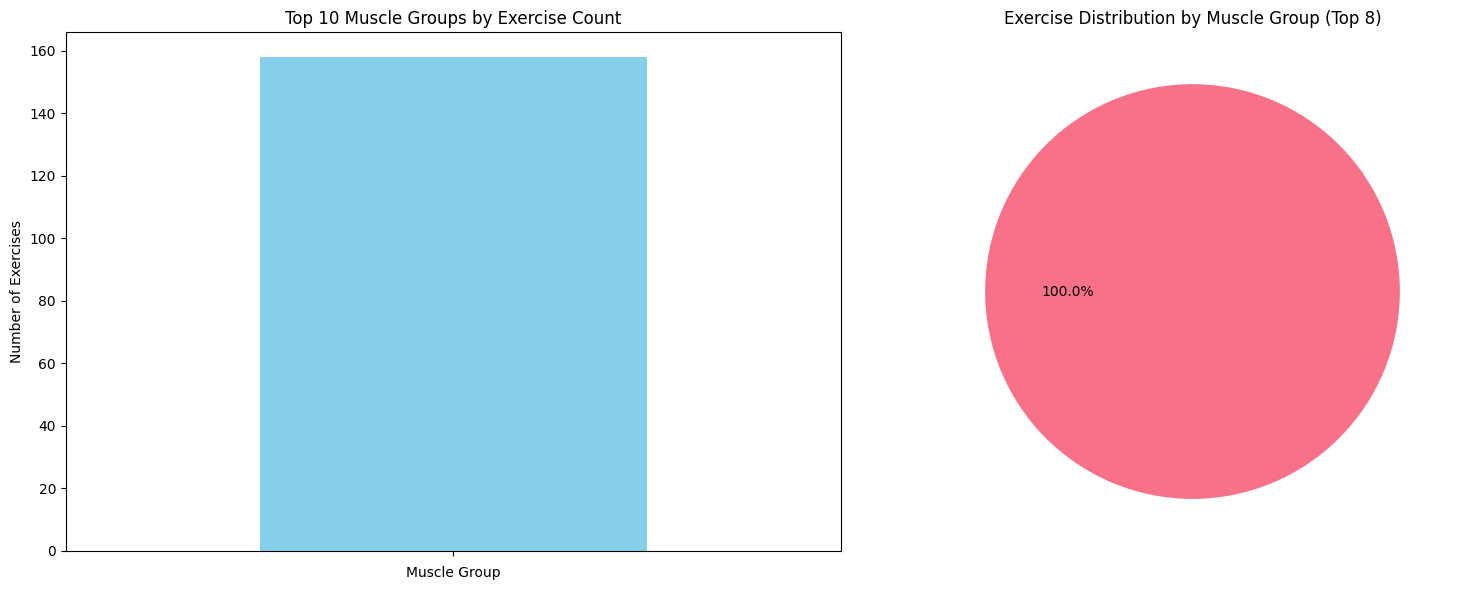

In [4]:
# Analyze muscle group distribution
muscle_groups = exercises_df["main_muscle_group"].value_counts()
print("🎯 Top 10 Muscle Groups:")
print(muscle_groups.head(10))

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
muscle_groups.head(10).plot(kind="bar", ax=ax1, color="skyblue")
ax1.set_title("Top 10 Muscle Groups by Exercise Count")
ax1.set_xlabel("Muscle Group")
ax1.set_ylabel("Number of Exercises")
ax1.tick_params(axis="x", rotation=45)

# Pie chart
muscle_groups.head(8).plot(kind="pie", ax=ax2, autopct="%1.1f%%")
ax2.set_title("Exercise Distribution by Muscle Group (Top 8)")
ax2.set_ylabel("")

plt.tight_layout()
plt.show()

In [5]:
# Interactive equipment analysis
equipment_counts = exercises_df["equipment"].value_counts()
print("🛠️ Equipment Distribution:")
print(equipment_counts.head(10))

# Interactive plotly chart
fig = px.bar(
    x=equipment_counts.head(12).values,
    y=equipment_counts.head(12).index,
    orientation="h",
    title="Exercise Count by Equipment Type",
    labels={"x": "Number of Exercises", "y": "Equipment"},
    color=equipment_counts.head(12).values,
    color_continuous_scale="viridis",
)
fig.update_layout(height=500, showlegend=False)
fig.show()

🛠️ Equipment Distribution:
equipment
    158
Name: count, dtype: int64


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [6]:
# Exercise recommendation system
def get_exercises_by_criteria(
    muscle_group=None, equipment=None, difficulty=None, limit=5
):
    """
    Get exercises based on specified criteria
    """
    filtered_df = exercises_df.copy()

    if muscle_group:
        filtered_df = filtered_df[
            filtered_df["main_muscle_group"].str.contains(
                muscle_group, case=False, na=False
            )
        ]

    if equipment:
        filtered_df = filtered_df[
            filtered_df["equipment"].str.contains(equipment, case=False, na=False)
        ]

    if difficulty:
        filtered_df = filtered_df[
            filtered_df["difficulty"].str.contains(difficulty, case=False, na=False)
        ]

    return filtered_df.head(limit)[
        ["name", "main_muscle_group", "equipment", "difficulty"]
    ]


# Example recommendations
print("🏋️ Example Exercise Recommendations:")
print("\n1. Beginner Chest Exercises:")
print(
    get_exercises_by_criteria(muscle_group="Chest", difficulty="Beginner").to_string(
        index=False
    )
)

print("\n2. Dumbbell Exercises:")
print(get_exercises_by_criteria(equipment="Dumbbells", limit=8).to_string(index=False))

🏋️ Example Exercise Recommendations:

1. Beginner Chest Exercises:
Empty DataFrame
Columns: [name, main_muscle_group, equipment, difficulty]
Index: []

2. Dumbbell Exercises:
Empty DataFrame
Columns: [name, main_muscle_group, equipment, difficulty]
Index: []


## 🤖 Machine Learning Preparation

In [7]:
# Prepare data for ML algorithms
print("🤖 Preparing data for Machine Learning...")

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

ml_df = exercises_df.copy()

# Encode categorical features
le_muscle = LabelEncoder()
le_equipment = LabelEncoder()
le_difficulty = LabelEncoder()

ml_df["muscle_group_encoded"] = le_muscle.fit_transform(
    ml_df["main_muscle_group"].fillna("Unknown")
)
ml_df["equipment_encoded"] = le_equipment.fit_transform(
    ml_df["equipment"].fillna("Unknown")
)
ml_df["difficulty_encoded"] = le_difficulty.fit_transform(
    ml_df["difficulty"].fillna("Unknown")
)

# Add text features
ml_df["name_length"] = ml_df["name"].str.len()
ml_df["description_length"] = ml_df["description"].str.len()
ml_df["form_cues_length"] = ml_df["form_cues"].str.len()

print("\n📊 ML-Ready Features:")
feature_cols = [
    "muscle_group_encoded",
    "equipment_encoded",
    "difficulty_encoded",
    "name_length",
    "description_length",
    "form_cues_length",
]
print(ml_df[["name"] + feature_cols].head())

print("\n🎯 Potential ML Applications:")
print("- Exercise recommendation system")
print("- Difficulty prediction")
print("- Equipment-based exercise clustering")
print("- Muscle group classification")
print("- Workout plan generation")

🤖 Preparing data for Machine Learning...

📊 ML-Ready Features:
                 name  muscle_group_encoded  equipment_encoded  \
0        Arnold Press                     0                  0   
1       Assisted Dips                     0                  0   
2   Assisted Pull-ups                     0                  0   
3         Barbell 21s                     0                  0   
4  Barbell Back Squat                     0                  0   

   difficulty_encoded  name_length  description_length  form_cues_length  
0                   2           12                  32               108  
1                   1           13                  20                94  
2                   1           17                  24                96  
3                   2           11                  35                85  
4                   2           18                  91               124  

🎯 Potential ML Applications:
- Exercise recommendation system
- Difficulty prediction
- E

## 💾 Export Data

In [10]:
# Export processed data
output_dir = "data_exports"
os.makedirs(output_dir, exist_ok=True)

# Export main datasets
exercises_df.to_csv(f"{output_dir}/exercises_raw.csv", index=False)
ml_df.to_csv(f"{output_dir}/exercises_ml_ready.csv", index=False)

print(f"💾 Data exported to '{output_dir}/' directory")
print("✅ Analysis complete! Ready for ML model development.")

💾 Data exported to 'data_exports/' directory
✅ Analysis complete! Ready for ML model development.
